In [ ]:
maskyz = (y >= -2) & (y <= 2)
y = y[maskyz]
z = z[maskyz]

ne = ne[:, maskyz, :][:, :, maskyz]

# 定义x轴范围列表，可以绘制多个x区间内的密度图
# ranges = [(14, 26)]
ranges = [(15.6, 16.4),(16.4,17.2),(17.2,17.9),(17.9,18.8),(18.8,19.6),(19.6,20.4),(20.4,21.2),(21.2,22),
          (22,22.7),(22.7,23.5),(23.5,24.4)]

# === 绘制每个x范围内的电子数密度分布 ===
for idx, (start, end) in enumerate(ranges, start=1):
    mask = (x >= start) & (x <= end) # 筛选x坐标在范围内的索引
    # masky = (y >= -2) & (y <= 2)
    # maskz = (z >= -2) & (z <= 2)
    # y = y[masky]
    # z = z[maskz]
    ne_sum = np.sum(ne[mask, :, :], axis=0) # 对选定范围内x维度上的电子数密度求和，得到y-z平面的二维分布
    Y, Z = np.meshgrid(y, z, indexing='ij') # 生成网格坐标，方便画二维色图，注意meshgrid默认是X,Y顺序，这里用'y','z'

    # 创建绘图窗口
    plt.figure(figsize=(10, 6))
    c = plt.pcolormesh(Y, Z, ne_sum, shading='auto', cmap="OrRd") # 绘制二维伪彩色图，shading='auto'自动优化网格间距，colormap用 OrRd（橙红色调）
    plt.colorbar(c, label='$n_e / n_c$') # 添加颜色条，标注电子密度单位
    plt.title(f'Electron Number Density from $x={start}$ to $x={end}$', fontsize=16)   # 设置标题，显示x范围
    plt.xlabel('y ($\mu$m)', fontsize=14)  # 设置x、y轴标签及单位
    plt.ylabel('z ($\mu$m)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7) # 添加网格线，美化图形
    
    # 保存图片（如果开启保存选项）
    if save_fig:
        save_path = os.path.join(output_dir, f"无磁场脉冲光子焦点{idx}_x_{start:.1f}_to_{end:.1f}.jpg")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    # 显示图形
    plt.show()

    # === 求和整个网格的密度 ===
    total_density = np.sum(ne_sum)
    print(f"Total density in range x={start} to x={end}: {total_density:.2e}")

    # === 提取中心线的密度分布 ===
    # 假设中心线是 y 方向的中心位置
    y_center_index = len(y) // 2  # y 的中心索引
    center_line_density = ne_sum[y_center_index, :]  # 提取中心线的密度分布

    # 绘制中心线的密度分布折线图
    plt.figure(figsize=(10, 6))
    plt.plot(z, center_line_density, label=f'Center Line Density at y={y[y_center_index]:.2f} μm', linewidth=2)
    plt.title(f'Center Line Density from $x={start}$ to $x={end}$', fontsize=16)
    plt.xlabel('z ($\mu$m)', fontsize=14)
    plt.ylabel('$n_e / n_c$', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 保存图片（如果开启保存选项）
    if save_fig:
        save_path = os.path.join(output_dir, f"中心线密度_{idx}_x_{start:.1f}_to_{end:.1f}.jpg")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    # 显示图形
    plt.show()

    import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

# === 数据准备 ===
# 假设 z 和 center_line_density 是从前面代码中提取的中心线密度分布
x = z  # x轴数据（例如z轴坐标）
y = center_line_density / center_line_density.max()  # 将密度归一化到最大值为1

# === 平滑信号 ===
# 使用高斯滤波对信号进行平滑处理，减少噪声影响
y_smooth = gaussian_filter1d(y, sigma=5)

# === 识别主峰 ===
# 使用 find_peaks 函数找到所有峰值，并选择其中最高的主峰
peaks, _ = find_peaks(y_smooth, height=0.1)  # 设置最小高度阈值
if len(peaks) == 0:
    raise ValueError("未检测到峰值")
main_peak_idx = peaks[np.argmax(y_smooth[peaks])]  # 选择最高峰
x_peak = x[main_peak_idx]  # 主峰对应的x值
y_peak = y_smooth[main_peak_idx]  # 主峰的高度

# === 确定局部搜索区域 ===
# 为了提高计算效率，只在主峰附近的局部区域进行计算
peak_val = y_peak * 0.1  # 主峰高度的1%作为阈值
left_bound = np.where(y_smooth[:main_peak_idx] < peak_val)[0]
left_bound = left_bound[-1] + 1 if left_bound.size > 0 else 0  # 左边界

right_bound = np.where(y_smooth[main_peak_idx:] < peak_val)[0]
right_bound = right_bound[0] + main_peak_idx if right_bound.size > 0 else len(x) - 1  # 右边界

# 确保边界合理
search_region = slice(max(0, left_bound), min(len(x), right_bound + 1))
x_local = x[search_region]  # 局部区域的x值
y_local = y_smooth[search_region]  # 局部区域的平滑信号

# === 插值 ===
# 在局部区域进行插值，以获得更精确的信号表示
f = interp1d(x_local, y_local, kind='cubic')  # 使用三次样条插值
x_dense = np.linspace(x_local[0], x_local[-1], 1000)  # 生成密集的x值
y_dense = f(x_dense)  # 计算插值后的信号

# === 计算1/e宽度 ===
# 计算1/e倍的峰值高度
y_1e = y_peak / np.e  # 1/e 倍的峰值高度

# 在插值数据中找到主峰位置
peak_idx_dense = np.argmax(y_dense)  # 主峰在插值数据中的索引
left_side = y_dense[:peak_idx_dense]  # 主峰左侧的数据
right_side = y_dense[peak_idx_dense:]  # 主峰右侧的数据

# 找到1/e交点
left_cross_idx = np.where(left_side >= y_1e)[0][0] if np.any(left_side >= y_1e) else 0  # 左侧交点索引
right_cross_idx = np.where(right_side >= y_1e)[0][-1] + peak_idx_dense if np.any(right_side >= y_1e) else len(y_dense) - 1  # 右侧交点索引

left_cross = x_dense[left_cross_idx]  # 左侧交点的x值
right_cross = x_dense[right_cross_idx]  # 右侧交点的x值

# 计算1/e宽度
fwhm_1e = right_cross - left_cross  # 1/e宽度
print(f"1/e Width = {fwhm_1e:.4f}")
print(fwhm_1e / 3)  # 如果需要进一步处理宽度

# === 可视化结果 ===
plt.figure(figsize=(10, 6))
plt.plot(x, y, '.', alpha=0.5, label='Raw Data')  # 原始数据
plt.plot(x, y_smooth, 'b-', label='Smoothed', linewidth=2)  # 平滑后的信号
plt.axhline(y_1e, color='gray', linestyle='--', label='1/e Max')  # 1/e高度的水平线
plt.axvline(left_cross, color='r', linestyle='-', label='1/e Width Edges')  # 左侧交点
plt.axvline(right_cross, color='r', linestyle='-')  # 右侧交点
plt.axvspan(x_local[0], x_local[-1], alpha=0.1, color='green', label='Search Region')  # 局部搜索区域
plt.title(f"1/e Width = {fwhm_1e:.4f}")  # 图标题
plt.xlabel('z ($\mu$m)')  # x轴标签
plt.ylabel('Normalized Density')  # y轴标签
plt.legend()  # 图例
plt.grid(True)  # 网格
plt.show()

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:117: SyntaxWarning: invalid escape sequence '\m'
<>:144: SyntaxWarning: invalid escape sequence '\m'
<>:145: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:117: SyntaxWarning: invalid escape sequence '\m'
<>:144: SyntaxWarning: invalid escape sequence '\m'
<>:145: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_205753/3223417321.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('y ($\mu$m)', fontsize=14)
/tmp/ipykernel_205753/3223417321.py:48: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('z ($\mu$m)', fontsize=14)
/tmp/ipykernel_205753/3223417321.py:63: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('z ($\mu$m)', fontsize=14)
/tmp/ipyke

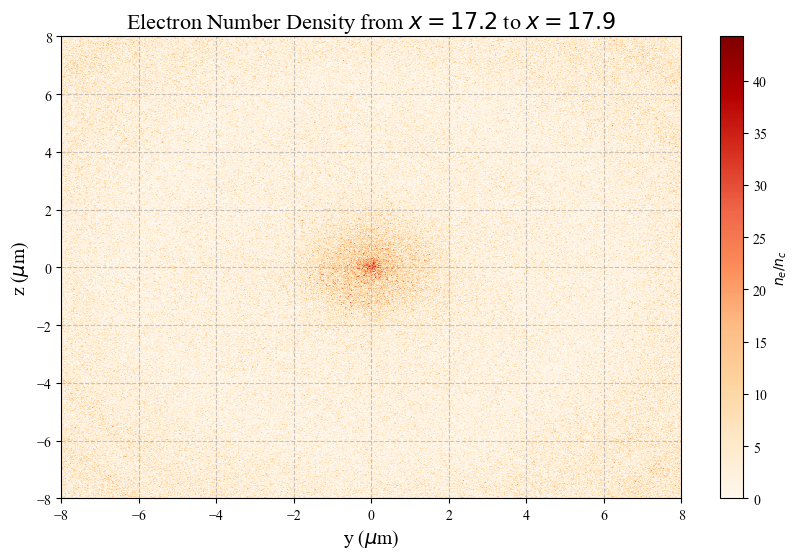

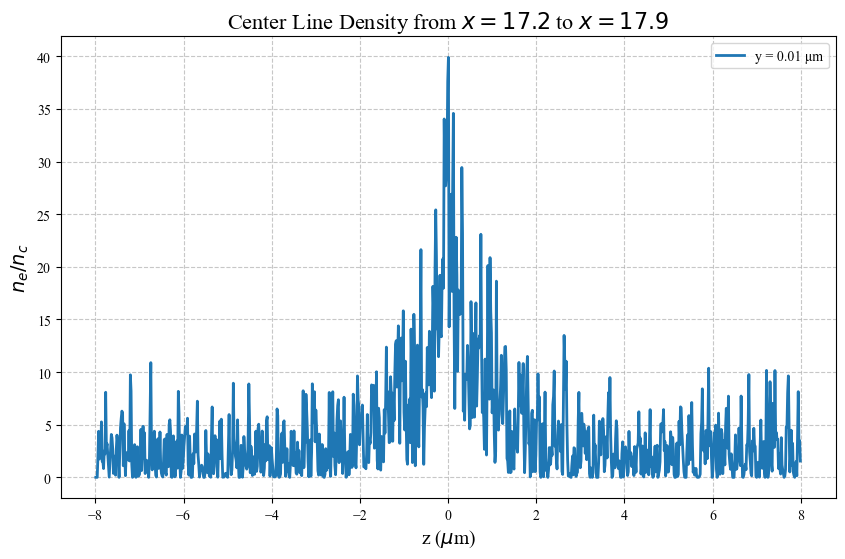

1/e 宽度 = 2.4541 μm


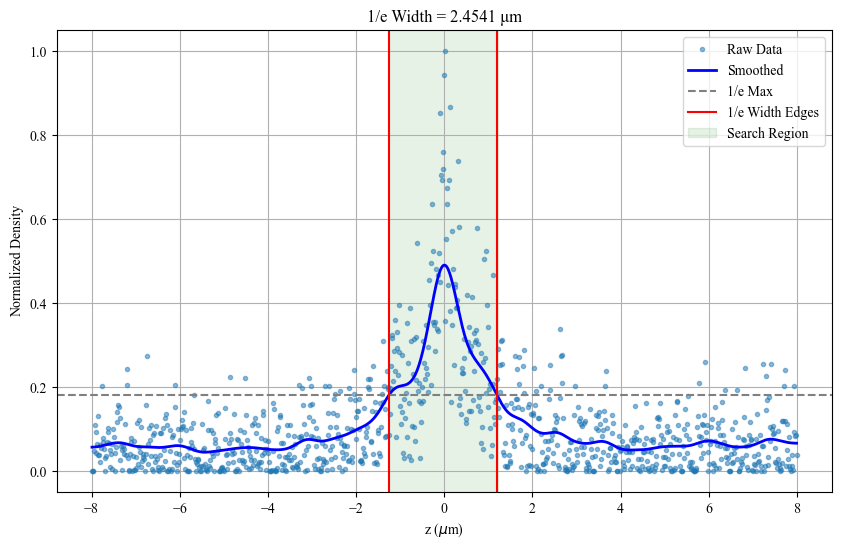

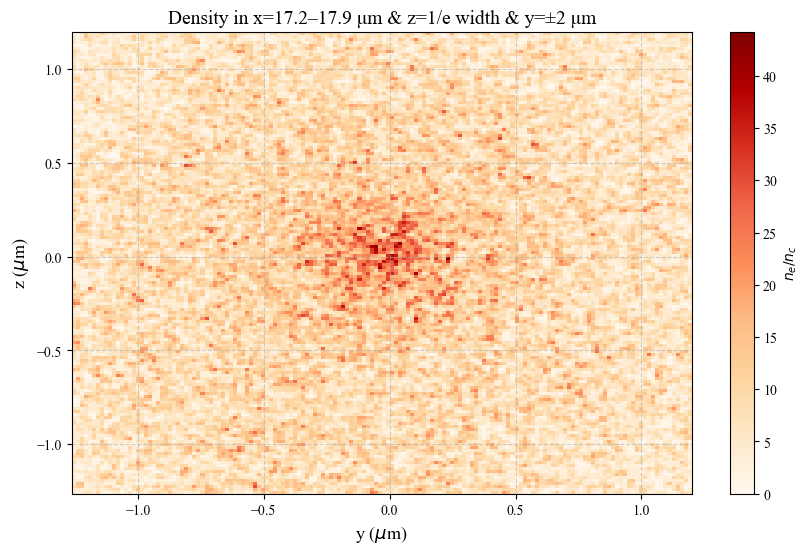

✅ Total normalized electron density in this region: 2.1313e+05


In [6]:
import sdf_helper as sh
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

# === 参数设置 ===
base_path = '/media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch-set2/epoch3d/ju2024a/10kev无磁场'
file_prefix = 'density'
file_suffix = '.sdf'
file_index = 18
save_fig = False
output_dir = "/media/lan/Lexar/EPOCH代码/图片/20250701"
os.makedirs(output_dir, exist_ok=True)

# 构造路径并读取数据
file_name = f"{file_prefix}{file_index:04d}{file_suffix}"
file_path = os.path.join(base_path, file_name)
den_crit = 0.17419597124e28
Density_Data = sh.getdata(file_path)
ne = Density_Data.Derived_Number_Density_Photon.data / den_crit
x = Density_Data.Grid_Grid_mid.data[0] / 1e-6
y = Density_Data.Grid_Grid_mid.data[1] / 1e-6
z = Density_Data.Grid_Grid_mid.data[2] / 1e-6

# === 分析的 x 范围 ===
start, end = 17.2, 17.9

# # 筛选 y-z 范围
# maskyz = (y >= -2) & (y <= 2)
# y = y[maskyz]
# z = z[maskyz]
# ne = ne[:, maskyz, :][:, :, maskyz]

# 筛选 x 范围
mask = (x >= start) & (x <= end)
ne_sum = np.sum(ne[mask, :, :], axis=0)

# 创建 y-z 平面图
Y, Z = np.meshgrid(y, z, indexing='ij')
plt.figure(figsize=(10, 6))
c = plt.pcolormesh(Y, Z, ne_sum, shading='auto', cmap="OrRd")
plt.colorbar(c, label='$n_e / n_c$')
plt.title(f'Electron Number Density from $x={start}$ to $x={end}$', fontsize=16)
plt.xlabel('y ($\mu$m)', fontsize=14)
plt.ylabel('z ($\mu$m)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
if save_fig:
    save_path = os.path.join(output_dir, f"电子密度_x_{start}_to_{end}.jpg")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# === 提取中心线 ===
y_center_index = len(y) // 2
center_line_density = ne_sum[y_center_index, :]

# 画中心线密度图
plt.figure(figsize=(10, 6))
plt.plot(z, center_line_density, label=f'y = {y[y_center_index]:.2f} μm', linewidth=2)
plt.title(f'Center Line Density from $x={start}$ to $x={end}$', fontsize=16)
plt.xlabel('z ($\mu$m)', fontsize=14)
plt.ylabel('$n_e / n_c$', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
if save_fig:
    save_path = os.path.join(output_dir, f"中心线密度_x_{start}_to_{end}.jpg")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# === 1/e 宽度计算 ===
x = z
y_norm = center_line_density / center_line_density.max()
y_smooth = gaussian_filter1d(y_norm, sigma=15)

# 找主峰
peaks, _ = find_peaks(y_smooth, height=0.1)
if len(peaks) == 0:
    raise ValueError("未检测到峰值")
main_peak_idx = peaks[np.argmax(y_smooth[peaks])]
x_peak = x[main_peak_idx]
y_peak = y_smooth[main_peak_idx]

# 找 1/e 区域
y_1e = y_peak / np.e
left_bound = np.where(y_smooth[:main_peak_idx] < y_1e)[0]
left_bound = left_bound[-1] + 1 if left_bound.size > 0 else 0
right_bound = np.where(y_smooth[main_peak_idx:] < y_1e)[0]
right_bound = right_bound[0] + main_peak_idx if right_bound.size > 0 else len(x) - 1
search_region = slice(max(0, left_bound), min(len(x), right_bound + 1))
x_local = x[search_region]
y_local = y_smooth[search_region]

# 插值并求宽度
f = interp1d(x_local, y_local, kind='cubic')
x_dense = np.linspace(x_local[0], x_local[-1], 1000)
y_dense = f(x_dense)
peak_idx_dense = np.argmax(y_dense)
left_cross_idx = np.where(y_dense[:peak_idx_dense] >= y_1e)[0][0] if np.any(y_dense[:peak_idx_dense] >= y_1e) else 0
right_cross_idx = np.where(y_dense[peak_idx_dense:] >= y_1e)[0][-1] + peak_idx_dense if np.any(y_dense[peak_idx_dense:] >= y_1e) else len(y_dense) - 1
left_cross = x_dense[left_cross_idx]
right_cross = x_dense[right_cross_idx]
fwhm_1e = right_cross - left_cross

print(f"1/e 宽度 = {fwhm_1e:.4f} μm")

# 可视化宽度识别
plt.figure(figsize=(10, 6))
plt.plot(x, y_norm, '.', alpha=0.5, label='Raw Data')
plt.plot(x, y_smooth, 'b-', label='Smoothed', linewidth=2)
plt.axhline(y_1e, color='gray', linestyle='--', label='1/e Max')
plt.axvline(left_cross, color='r', linestyle='-', label='1/e Width Edges')
plt.axvline(right_cross, color='r', linestyle='-')
plt.axvspan(x_local[0], x_local[-1], alpha=0.1, color='green', label='Search Region')
plt.title(f"1/e Width = {fwhm_1e:.4f} μm")
plt.xlabel('z ($\mu$m)')
plt.ylabel('Normalized Density')
plt.legend()
plt.grid(True)
plt.show()

# 正确的筛选：y 限制为 ±2 μm，z 限制为 1/e 宽度
y_mask = (y >= left_cross) & (y <= right_cross)
z_mask = (z >= left_cross) & (z <= right_cross)

# 更新坐标轴
y_zoom = y[y_mask]
z_zoom = z[z_mask]

# 应用 mask 到 ne 数据
ne_zoom = ne[:, y_mask, :][:, :, z_mask]

# 在选定 x 区间上求和
ne_zoom_sum = np.sum(ne_zoom[mask, :, :], axis=0)

# 网格并绘图
Y_zoom, Z_zoom = np.meshgrid(y_zoom, z_zoom, indexing='ij')

plt.figure(figsize=(10, 6))
c = plt.pcolormesh(Y_zoom, Z_zoom, ne_zoom_sum, shading='auto', cmap="OrRd")
plt.colorbar(c, label='$n_e / n_c$')
plt.title(f'Density in x={start}–{end} μm & z=1/e width & y=±2 μm', fontsize=14)
plt.xlabel('y ($\mu$m)', fontsize=13)
plt.ylabel('z ($\mu$m)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
if save_fig:
    save_path = os.path.join(output_dir, f"zoomed_density_x{start:.1f}_to_{end:.1f}_1e_z_y2.jpg")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# 计算总归一化密度
total_density = np.sum(ne_zoom_sum)
print(f"✅ Total normalized electron density in this region: {total_density:.4e}")